In [3]:
import torch
import networkx as nx
import os
from typing import List
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from common_utils.stg_utils import Node
from scipy.spatial import distance
from common_utils.process import graph_to_feature_vector, adj_to_normalized_tensor
from anomaly_generation.graph_corruption import Corruptor

TXT_FOLDER              = "../data/yolo_annotated_datasets/"
TRAINING_GRAPH_FOLDER = "../data/training_graphs/"
VIDEO_PARAMS_FOLDER = "../data/video_parameters/"
TESTING_GRAPH_FOLDER = "../data/testing_graphs/"
LABELS_FOLDER = "../data/testing_labels/"

TRAINING_PICKLE = "../data/torch_datasets/train_dataset_{}fpv_noadoc.pt"
MODEL_PICKLE = "../data/models/model_trained_on_{}fpv_noadoc.pt"

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
dataset_name = "AvenueDataset"
txt_path = os.path.join(TXT_FOLDER, f"{dataset_name}ResultsTraining.txt")
df = pd.read_csv(txt_path, sep=",",header=0)
df = df[df["video_no"] == 21]
pd.options.display.max_colwidth = 500
df

,path,video_no,video_amount,frame_no,frame_amount,node_id,x1,y1,x2,y2,conf,detclass
0,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1,1364,5752,177,118,215,225,0,0
1,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1,1364,5742,312,307,329,321,0,14
2,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1,1364,5735,442,119,478,230,0,0
3,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1,1364,5712,616,95,643,263,0,0
4,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1,1364,5553,396,105,443,231,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10353,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1363,1364,6072,599,117,635,237,0,0
10354,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1364,1364,6133,383,121,404,215,0,0
10355,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1364,1364,6126,387,117,427,234,0,0
10356,/Users/xiaokeai/Downloads/yolov7-main/datasets/Avenue Dataset/training_videos/01.avi,21,37,1364,1364,6120,312,307,329,322,0,14


In [5]:
df.frame_no.max()

1364

In [6]:
CLASSES_LIST =  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear']

def generate_spatial_graphs(df):
    # preprocessing the df
    indexlist=[*range(0, 78, 1)]
    mapdict = {indexlist[i]: CLASSES_LIST[i] for i in range(len(indexlist))}

    df['path_org'] = df['path']
    df['path'] = df['path'].str.extract(r'(\d+)(?!.*\d)')
    df['path'].astype(int)
    df['video_no'].astype(int)
    df['x1'].astype(float)
    df['x2'].astype(float)
    df['y1'].astype(float)
    df['y2'].astype(float)
    df['class_name']=df['detclass']
    df['class_name']=df.class_name.map(mapdict)
    df['centroid']= list(zip((df['x1'] + df['x2'])*0.5, (df['y1'] + df['y2'])*0.5))

    list_nameMapping=[]
    list_nameMapping=list(zip(df['path_org'], df['video_no']))
    list_nameMapping=list(dict.fromkeys(list_nameMapping))

    # feed data into the graph
    graphs = list()
    for i in df.video_no.unique():
        for j in range(df[df['video_no']==i]['frame_no'].min(),df[df['video_no']==i]['frame_no'].max()):
            graph = nx.Graph()
            df_new=df[(df['video_no']==i) & (df['frame_no']==j)]
            for row in df_new.iterrows():
                graph.add_node(Node(row[1][5],row[1][6],row[1][7],row[1][8],row[1][9],row[1][10],row[1][11],row[1][13],row[1][14]))
            for node1 in graph.nodes:
                for node2 in graph.nodes:
                    if node1.id == node2.id: continue
                    graph.add_edge(node1, node2, weight=distance.euclidean(node1.centroid, node2.centroid))
            graphs.append(graph)

    return graphs

In [7]:
# frames to graphs
graphs = generate_spatial_graphs(df)
len(graphs)

1363

In [8]:
# clipping the video to a videoclip
frames_per_video_clip = 500
graphs = graphs[0:500]
print(len(graphs))

500


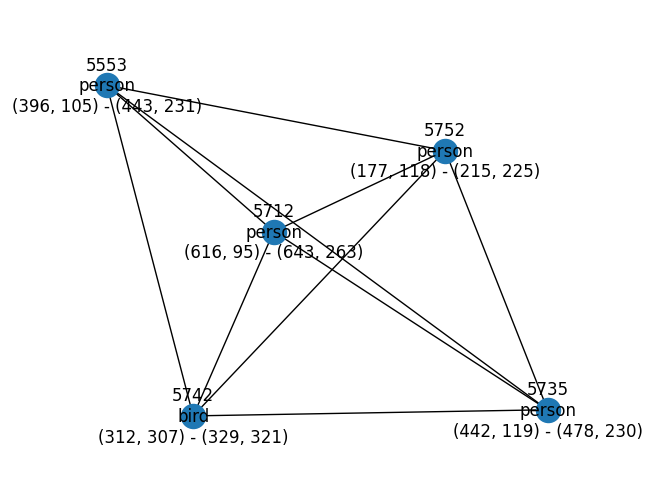

In [40]:
# visualize a graph

example_graph = graphs[0]
labels = {node : str(node.id) + "\n" + node.class_name + "\n" + node.boundary_box() for node in example_graph.nodes}
nx.draw(example_graph, labels=labels)

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.show()

In [10]:
def graph_seq_to_features_and_adjs(graph_seq: List[nx.Graph]) -> List[torch.Tensor]:
    features_and_adjs = [tensorize(graph) for graph in graph_seq]
    # padding
    while len(features_and_adjs) != frames_per_video_clip:
        features_and_adjs.append(get_empty_token())
    
    return features_and_adjs
            
def tensorize(graph: nx.Graph): # -> tuple(torch.Tensor):
    if len(graph.nodes)==0:
        return get_empty_token()
    features = graph_to_feature_vector(graph)
    adj = adj_to_normalized_tensor(nx.adjacency_matrix(graph))
    return features, adj

def get_empty_token(): # -> tuple(torch.Tensor):
    num_nodes = 20
    empty_features = torch.zeros(num_nodes, 85)
    empty_adj = torch.zeros(num_nodes, num_nodes)
    return empty_features, empty_adj

In [11]:
# processing videoclip
features_and_adjs = graph_seq_to_features_and_adjs(graphs)
len(features_and_adjs)

500

In [12]:
feature, adj = features_and_adjs[0]
print(feature.shape)
print(adj.shape)

torch.Size([5, 85])
torch.Size([5, 5])


In [13]:
# corrupting videoclip

width = 640
height = 360

corruptor = Corruptor(frame_width=width, frame_height=height)
corrupted_graph_seq = [corruptor.corrupt_graph(graph) for graph in graphs]


corr_features_and_adjs = graph_seq_to_features_and_adjs(corrupted_graph_seq)
len(corr_features_and_adjs)

500

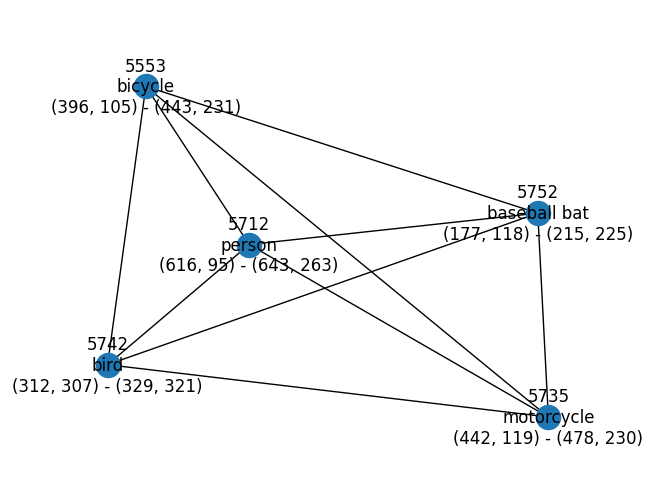

In [37]:
# visualize a graph
corrupted_graph = corrupted_graph_seq[0]

labels = {node : str(node.id) + "\n" + node.class_name + "\n" + node.boundary_box() for node in corrupted_graph.nodes}
nx.draw(corrupted_graph, labels=labels)

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.show()

In [15]:
import torch
from torch import nn
from embedding_training.embedding import GCN, AvgReadout
from embedding_training.transformer_classifier import Transformer, get_pos_onehot

class MyNet(nn.Module):
    def __init__(self, features_size, embedding_size, max_length = 1001, model_size=128, num_heads=4,num_blocks=1,dropout=0.1):
        super(MyNet, self).__init__()
        self.model_size = model_size
        self.model_size = embedding_size
        self.max_length = max_length

        self.emb = GCN(features_size, embedding_size, "prelu")

        self.readout = AvgReadout()

        self.pos = nn.Linear(max_length, self.model_size)

        self.transformer = Transformer(
            self.model_size,
            self.model_size,
            self.model_size,
            num_blocks,
            num_heads,
            dropout=dropout
        )
        self.classifier = nn.Linear(self.model_size, 1) # binary classification
        self.sigmoid =  nn.Sigmoid()
    
    def forward(self, seq_features_and_adjs):
        # seq is a list of (features, adj)
        #   embedding takes (features, adj)
        #   transformer takes (seq)
        
        print("Passing a sequence of 500 graphs, each of them having a variable number of nodes")
        embedded_seq = list()
        for i, (features, adj) in enumerate(seq_features_and_adjs):
            features = features.unsqueeze(0)
            adj = adj.unsqueeze(0)
            x = self.emb(features, adj) # * math.sqrt(self.d_model)
            if i==0:
                print(f"Shape of node-level embedding: {x.shape}")
            x = self.readout(x)
            embedded_seq.append(x)
        
        embedded_seq = torch.stack(embedded_seq, dim=1)
        print(f"Shape of graph-level embedding: {embedded_seq.shape}")

        pos = self.pos(get_pos_onehot(self.max_length).to(embedded_seq)).unsqueeze(0)
        x = embedded_seq.view(*(embedded_seq.size()[:-1] + (self.model_size,)))
        x += pos
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        x = self.sigmoid(x)
        print(f"Final shape: {x.shape}")
        return x

In [16]:
features_and_adjs += [tensorize(nx.Graph())]
corr_features_and_adjs += [tensorize(nx.Graph())]

In [17]:
model = MyNet(
    features_size=85,
    embedding_size=8, #value for embedding vector (MUST BE EVEN and dividible by nhead) a low number is probably enough since most of the features are one-hot encoded ones
    max_length=frames_per_video_clip+1
)
model.load_state_dict(torch.load(MODEL_PICKLE.format(frames_per_video_clip)))
prediction_for_normal = model.forward(features_and_adjs)
prediction_for_normal

Passing a sequence of 500 graphs, each of them having a variable number of nodes
Shape of node-level embedding: torch.Size([1, 5, 8])
Shape of graph-level embedding: torch.Size([1, 501, 8])
Final shape: torch.Size([1, 1])


tensor([[0.0289]], grad_fn=<SigmoidBackward0>)

In [18]:
prediction_for_anomaly = model.forward(corr_features_and_adjs)
prediction_for_anomaly

Passing a sequence of 500 graphs, each of them having a variable number of nodes
Shape of node-level embedding: torch.Size([1, 5, 8])
Shape of graph-level embedding: torch.Size([1, 501, 8])
Final shape: torch.Size([1, 1])


tensor([[0.0290]], grad_fn=<SigmoidBackward0>)

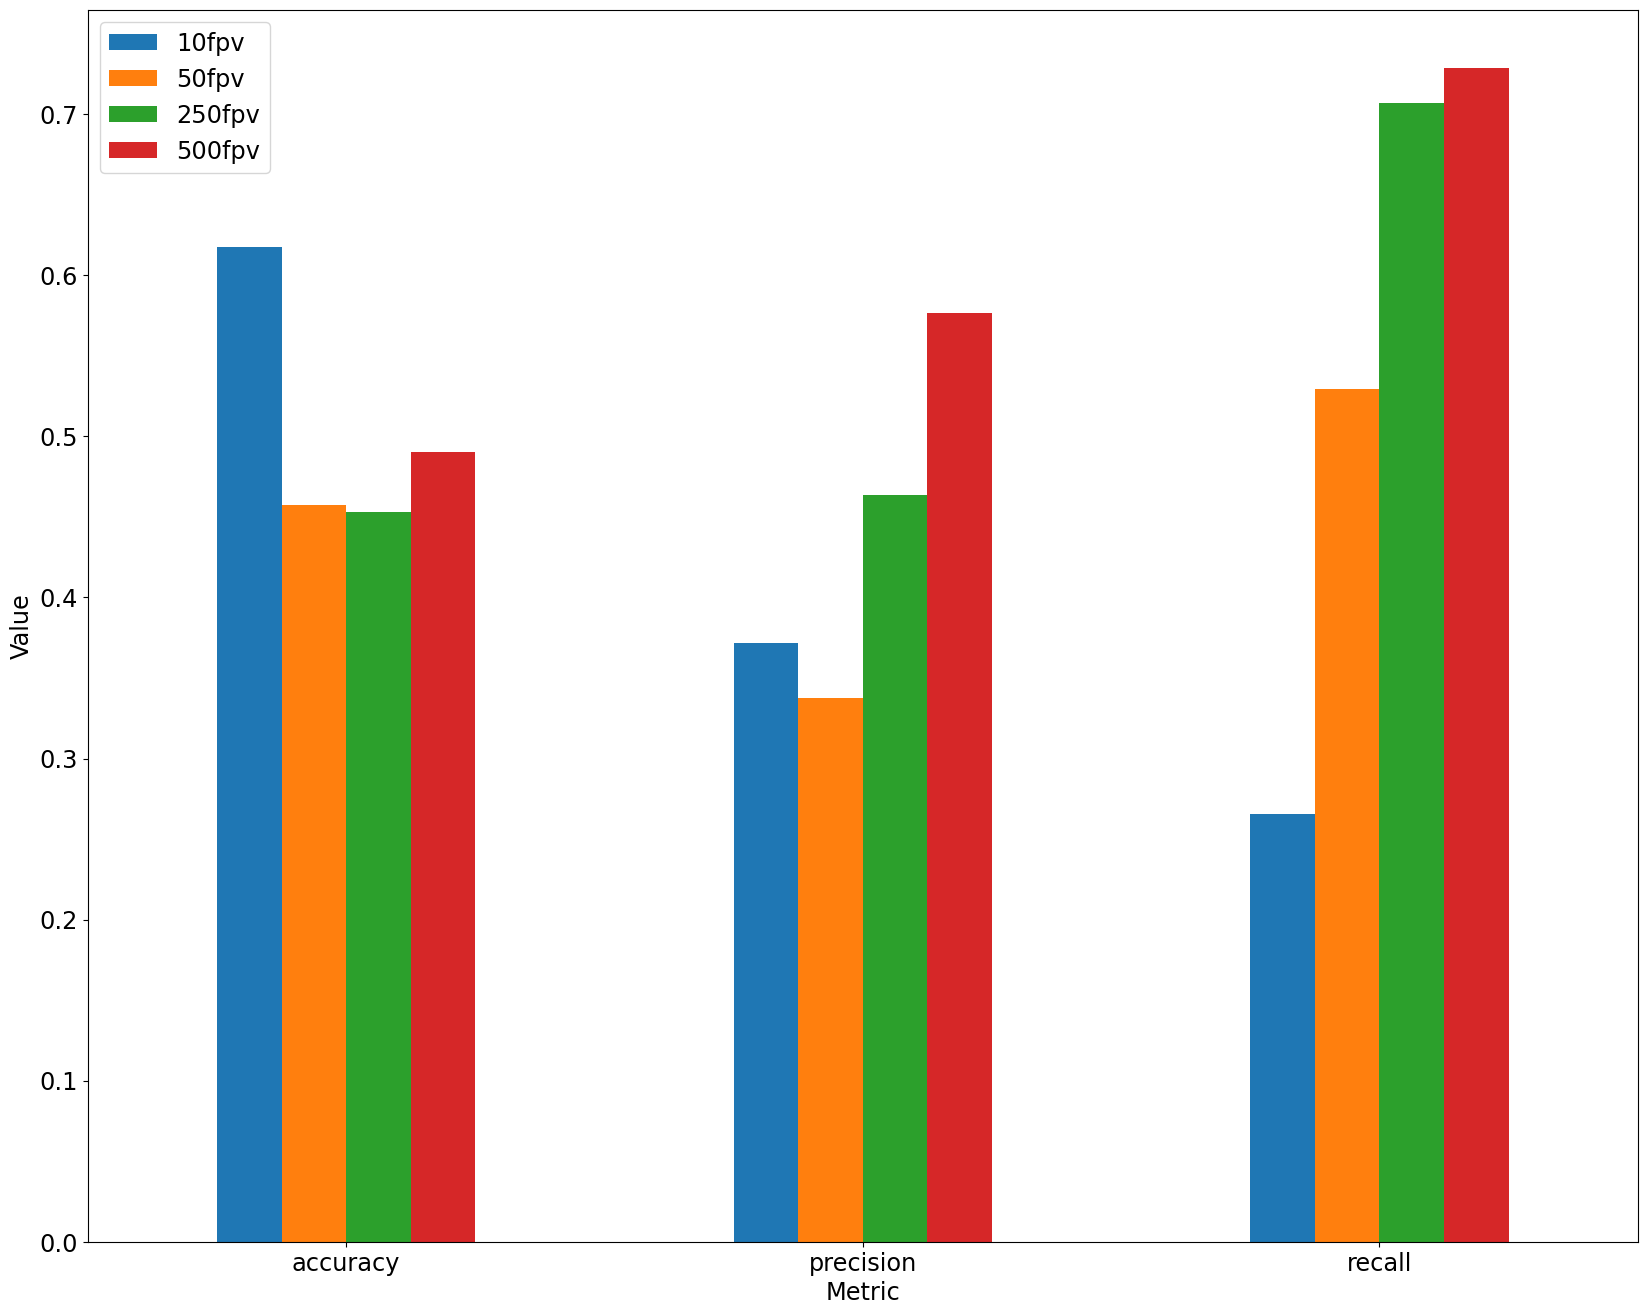

In [19]:
import matplotlib.pyplot as plt

df = pd.read_csv("results_for_plotting.csv", header=0, index_col="metric")
ax=df.plot.bar(figsize=(20, 16), fontsize='xx-large')
plt.xticks(rotation=0)
plt.xlabel("Metric", fontsize='xx-large')
plt.ylabel("Value", fontsize='xx-large')
plt.legend(loc='upper left', fontsize='xx-large')
fig=ax.get_figure()
plt.show()
fig.savefig('metrics_per_fpv.png')

In [20]:
df = pd.read_csv("results.csv", header=0)
df

,fpv,tp,fp,tn,fn,accuracy,precision,recall,datasets
0,500,169,124,11,63,0.490463,0.576792,0.728448,ShanghaiTech-Avenu-StreetScen
1,500,6,4,24,7,0.731707,0.600000,0.461538,Avenu
2,500,18,1,6,52,0.311688,0.947368,0.257143,ShanghaiTech
3,500,151,124,4,11,0.534483,0.549091,0.932099,StreetScen
4,50,678,1330,950,603,0.457175,0.337649,0.529274,ShanghaiTech-Avenu-StreetScen
5,50,12,53,220,30,0.736508,0.184615,0.285714,Avenu
6,50,54,43,180,239,0.453488,0.556701,0.184300,ShanghaiTech
7,50,612,1234,550,334,0.425641,0.331528,0.646934,StreetScen
8,10,1507,2548,9347,4170,0.617687,0.371640,0.265457,ShanghaiTech-Avenu-StreetScen
9,10,34,112,1251,142,0.834958,0.232877,0.193182,Avenu
